# Project Team
- Sai Sugeeth Kamineni 
- Vijay Sai Kondamadugu
- Christopher L. Frederick


# Style Transfer

For our style transfer we start with two images.  The "base" image and the "style" image.

This style transfer method is based on the work described in a Neural Algorithm of Artistic Style (http://arxiv.org/abs/1508.06576).  At each iteration work to minimize the the "content" loss in the combined image while working to minimize the "style" compared to the style image.  In addition, we measure the total loss to ensure that we maintain spatial continuity between the pixels in our combined image to ensure that it is still recongnizable.

In particular, we use transfer learning to start our model based on the deep convolutional neural network vgg19 (imagenet).  From there, we measure the style loss 
as defined as a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of a convnet.

The end result is that we are able to to capture color and texture information at different scales based on the depth of the network.

The results of this are very plesent, but leave a lot of challenges unsolved.  In particular, this method takes the style from the entire image, and therefore is not very good at identifying and adapting specific features.  For example, it cannot identify that all elves have pointy ears and then apply pointy ears to pictures of humans to transform them into elves.




### Import Libraries

In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K

import matplotlib.pyplot as plt

# Code based on the neural style transfer example provided by by the keras-team
#Source: https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py

Using TensorFlow backend.


### Setup the weights for our different loss components

In [0]:
# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

### Setup our model paramaters


In [0]:
# number of iterations
iterations = 10

# dimensions of the generated picture.
width, height = 582, 467
img_nrows = 400
img_ncols = int(width * img_nrows / height)

### Utility Functions to create the tensors from images and images from tensors.

In [0]:

# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Use the preprocess functions to get tensors

### Initialized the VGG19 with our 3 images

### Loss Functions

The "style loss" is designed to maintain the style of the reference image in the generated image.

It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image


content loss designed to maintain the "content" of the  base image in the generated image

Total variation loss, designed to keep the generated image locally coherent

In [0]:
# feature-wise outer product
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Setup so that we can compute loss and gradients in one pass

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

### Run the style transfer for several sets of images

In [7]:
images = {'setA':{'base':'style_transfer_source/bear.jpg','style':'style_transfer_source/fire.jpg'},
          'setB':{'base':'style_transfer_source/mage.jpg','style':'style_transfer_source/elemental.jpg'},
          'setC':{'base':'style_transfer_source/painted.jpg','style':'style_transfer_source/realistic.jpg'},
          'setD':{'base':'style_transfer_source/realistic.jpg','style':'style_transfer_source/painted.jpg'}}

for image_set in images:
  base_image_path = images[image_set]['base']
  style_reference_image_path = images[image_set]['style']
  result_prefix = f"{image_set}"

  # get tensor representations of our images
  base_image = K.variable(preprocess_image(base_image_path))
  style_reference_image = K.variable(preprocess_image(style_reference_image_path))

  # this will contain our generated image
  if K.image_data_format() == 'channels_first':
      combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
  else:
      combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

  # combine the 3 images into a single Keras tensor
  input_tensor = K.concatenate([base_image,
                                style_reference_image,
                                combination_image], axis=0)

  # build the VGG19 network with our 3 images as input
  # the model will be loaded with pre-trained ImageNet weights
  model = vgg19.VGG19(input_tensor=input_tensor,
                      weights='imagenet', include_top=False)

  # get the symbolic outputs of each "key" layer (we gave them unique names).
  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

  # combine these loss functions into a single scalar
  loss = K.variable(0.0)
  layer_features = outputs_dict['block5_conv2']
  base_image_features = layer_features[0, :, :, :] # The first layer is our base layer
  combination_features = layer_features[2, :, :, :] # Our combined layer

  # calculate the loss and update it
  loss = loss + content_weight * content_loss(base_image_features,
                                              combination_features) 
  
  # update the loss for our feature layers
  feature_layers = ['block1_conv1', 'block2_conv1',
                    'block3_conv1', 'block4_conv1',
                    'block5_conv1']

  for layer_name in feature_layers:
      layer_features = outputs_dict[layer_name]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      sl = style_loss(style_reference_features, combination_features)
      loss = loss + (style_weight / len(feature_layers)) * sl

  loss = loss + total_variation_weight * total_variation_loss(combination_image)

  # get the gradients of the generated image wrt the loss
  grads = K.gradients(loss, combination_image)

  outputs = [loss]
  if isinstance(grads, (list, tuple)):
      outputs += grads
  else:
      outputs.append(grads)

  f_outputs = K.function([combination_image], outputs)

  # run scipy-based optimization (L-BFGS) over the pixels of the generated image
  # so as to minimize the neural style loss  
  evaluator = Evaluator() # preprocess_image depends on the evaluator
  x = preprocess_image(base_image_path)

  for i in range(iterations):
      print('Start of iteration', i)
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                      fprime=evaluator.grads, maxfun=20)
      print('Current loss value:', min_val)
      # save current generated image
      img = deprocess_image(x.copy())
      fname = 'style_transfer_results/' + result_prefix + '_at_iteration_%d.png' % i
      save_img(fname, img)
      end_time = time.time()
      print('Image saved as', fname)
      print('Iteration %d completed in %ds' % (i, end_time - start_time))











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start of iteration 0
Current loss value: 2638216700.0
Image saved as style_transfer_results/setA_at_iteration_0.png
Iteration 0 completed in 10s
Start of iteration 1
Current loss value: 1561231600.0
Image saved as style_transfer_results/setA_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 1281011700.0
Image saved as style_transfer_results/setA_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 1135049900.0
Image saved as style_transfer_results/setA_at_iteration_3.png
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 1043613630.0
Image saved as style_transfer_results/setA_at_iteration_4.png
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 981138940.0
Image saved as style_transfer_results/setA_at_iteration_5.png
Iteration 5 completed in 7s
Start of iteration 6
Current los

### Plot the results

In [0]:
def show_results(set_name):
  images[set_name]['base']
  plt.figure(figsize=(10, 5))
  content = load_img(images[set_name]['base']) 
  style = load_img(images[set_name]['style'])

  plt.subplot(1, 2, 1)
  plt.imshow(content)
  plt.title('Base Image')

  plt.subplot(1, 2, 2)
  plt.imshow(style)
  plt.title('Style Image')

  plt.figure(figsize=(10, 10))
  best = load_img(f'style_transfer_results/{set_name}_at_iteration_9.png') 
  plt.imshow(best)
  plt.title('Final Output Image')
  plt.show()

Set A

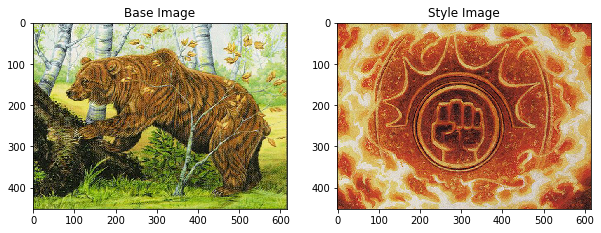

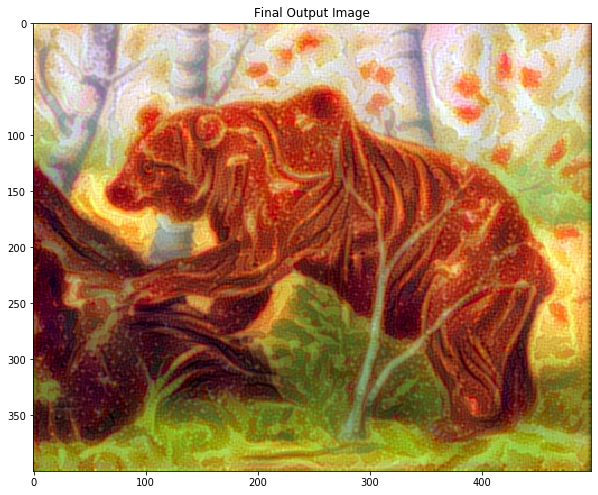

In [9]:
show_results("setA")

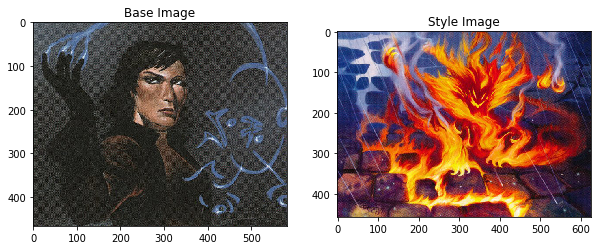

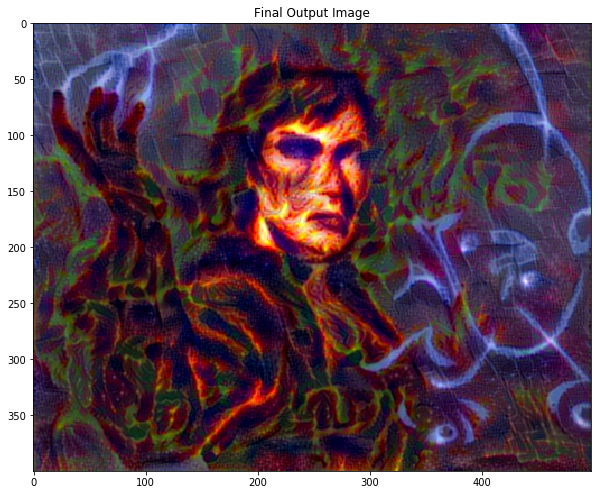

In [10]:
show_results("setB")

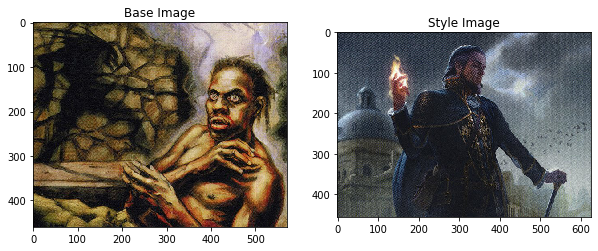

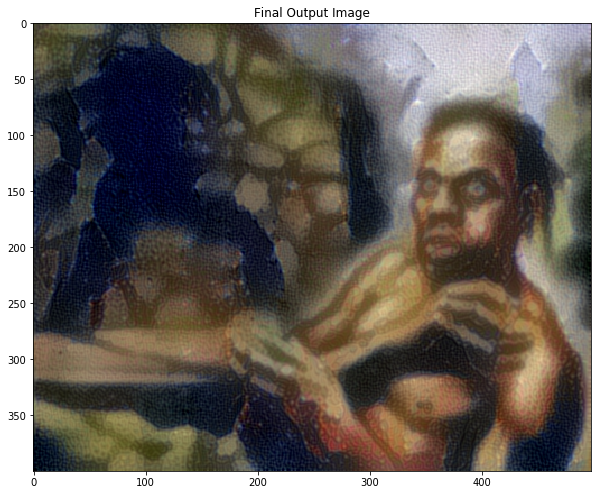

In [11]:
show_results("setC")

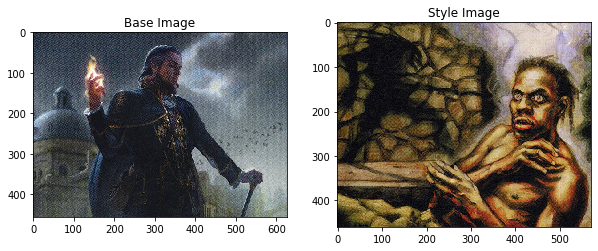

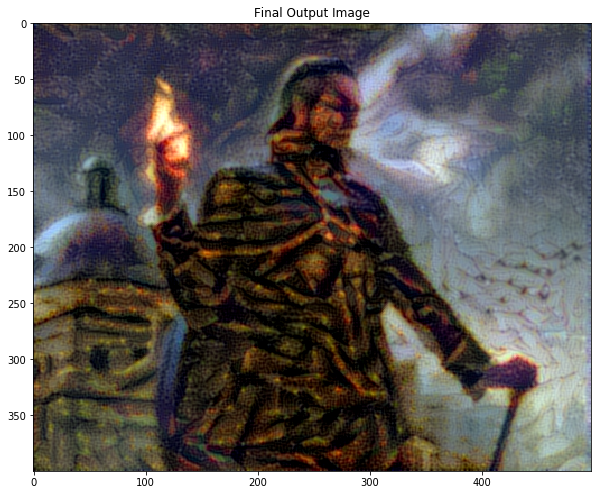

In [12]:
show_results("setD")